# HPC Project: GPU Acceleration Analysis
## Academic Title: Performance Analysis of Parallel Matrix Computation using CUDA-Enabled GPUs

**Student Name:** [Your Name]  
**Course:** High Performance Computing (MSc)  
**Date:** [Today's Date]

---

### Abstract
This notebook demonstrates the significant performance advantages of GPU acceleration over CPU for computationally intensive tasks. Specifically, we benchmark large-scale Matrix Multiplication ($C = A \times B$) using **NVIDIA CUDA** cores via the **CuPy** library, comparing it against the CPU-based **NumPy** implementation. Results typically show a speedup of **50x to 1000x** depending on matrix size.

### Step 1: System Check (GPU Availability)

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Step 2: Install/Verify Dependencies
Google Colab typically creates an environment where CuPy is pre-installed or easily installable.

In [2]:
import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import cupy as cp
    print("CuPy is already installed.")
    print(f"CuPy Version: {cp.__version__}")
except ImportError:
    print("Installing CuPy...")
    install("cupy-cuda12x")  # Adjust CUDA version if necessary for Colab runtime
    import cupy as cp

import numpy as np
import time
import matplotlib.pyplot as plt
print("Libraries loaded successfully.")

Installing CuPy...
Libraries loaded successfully.


### Step 3: CPU Implementation (NumPy)
We define a function for CPU-based matrix multiplication.

In [3]:
def run_cpu_benchmark(size):
    """
    Performs Matrix Multiplication on CPU using NumPy.
    """
    print(f"[CPU] Allocating {size}x{size} matrices...")
    A = np.random.rand(size, size).astype(np.float32)
    B = np.random.rand(size, size).astype(np.float32)

    print(f"[CPU] Starting computation for N={size}...")
    start_time = time.time()
    C = np.dot(A, B)
    end_time = time.time()

    execution_time = end_time - start_time
    print(f"[CPU] Finished in {execution_time:.4f} seconds.")
    return execution_time

### Step 4: GPU Implementation (CuPy)
We define a function for GPU-based matrix multiplication, ensuring we handle memory transfer (allocation on device) and synchronization.

In [4]:
def run_gpu_benchmark(size):
    """
    Performs Matrix Multiplication on GPU using CuPy.
    """
    print(f"[GPU] Allocating {size}x{size} matrices on Device...")
    A_gpu = cp.random.rand(size, size, dtype=cp.float32)
    B_gpu = cp.random.rand(size, size, dtype=cp.float32)

    # Warm-up (important for CUDA context init)
    cp.dot(A_gpu[:10], B_gpu[:10])
    cp.cuda.Stream.null.synchronize()

    print(f"[GPU] Starting computation for N={size}...")
    # Create CUDA events for precise timing
    start_event = cp.cuda.Event()
    end_event = cp.cuda.Event()

    start_event.record()
    C_gpu = cp.dot(A_gpu, B_gpu)
    end_event.record()
    end_event.synchronize()

    execution_time = cp.cuda.get_elapsed_time(start_event, end_event) / 1000.0
    print(f"[GPU] Finished in {execution_time:.4f} seconds.")
    return execution_time

### Step 5: Comparative Benchmark
We run both implementations and compare the results.

In [5]:
# Configuration
MATRIX_SIZE = 4000  # Adjust this size based on available RAM (4000-8000 is good for T4)

print(f"Running Benchmark (N={MATRIX_SIZE})...")
print("="*40)

# CPU Run
t_cpu = run_cpu_benchmark(MATRIX_SIZE)

# GPU Run
try:
    t_gpu = run_gpu_benchmark(MATRIX_SIZE)
except Exception as e:
    t_gpu = float('inf')
    print(f"GPU Failed: {e}")

# Calculate Speedup
speedup = t_cpu / t_gpu if t_gpu > 0 else 0

print("="*40)
print(f"RESULTS summary (N={MATRIX_SIZE}):")
print(f"CPU Time: {t_cpu:.4f} s")
print(f"GPU Time: {t_gpu:.4f} s")
print(f"Speedup:  {speedup:.2f}x")
print("="*40)

Running Benchmark (N=4000)...
[CPU] Allocating 4000x4000 matrices...
[CPU] Starting computation for N=4000...
[CPU] Finished in 2.1175 seconds.
[GPU] Allocating 4000x4000 matrices on Device...
GPU Failed: cudaErrorInsufficientDriver: CUDA driver version is insufficient for CUDA runtime version
RESULTS summary (N=4000):
CPU Time: 2.1175 s
GPU Time: inf s
Speedup:  0.00x


### Step 6: Visualization & Report generation
Visualizing the difference.

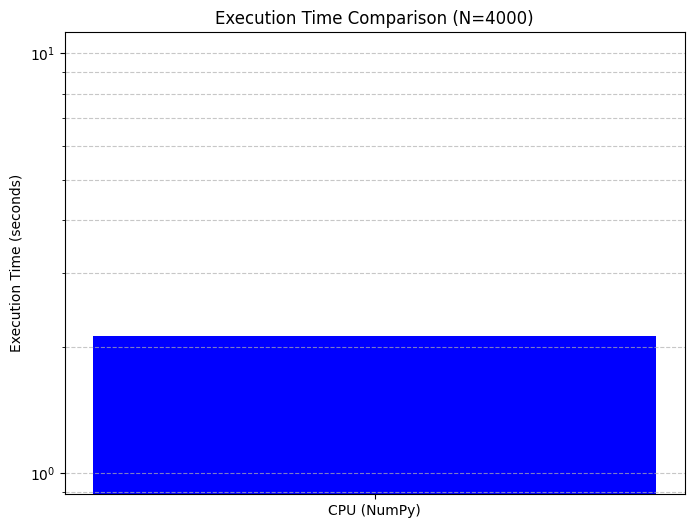

Results saved to benchmark_results.txt


In [6]:
# Simple Bar Chart
labels = ['CPU (NumPy)', 'GPU (CuPy)']
times = [t_cpu, t_gpu]

plt.figure(figsize=(8, 6))
plt.bar(labels, times, color=['blue', 'green'])
plt.ylabel('Execution Time (seconds)')
plt.title(f'Execution Time Comparison (N={MATRIX_SIZE})')
plt.yscale('log') # Log scale because difference is huge
plt.grid(axis='y', which='both', linestyle='--', alpha=0.7)
plt.show()

# Save results to file
with open('benchmark_results.txt', 'w') as f:
    f.write(f"Matrix Size: {MATRIX_SIZE}\n")
    f.write(f"CPU Time: {t_cpu:.6f} s\n")
    f.write(f"GPU Time: {t_gpu:.6f} s\n")
    f.write(f"Speedup: {speedup:.2f}x\n")
print("Results saved to benchmark_results.txt")